# Style Transfer with Convolutional Neural Networks

In [29]:
import torchvision.models as models
from importlib import reload
import torch
import numpy as np
from torch.optim import LBFGS, SGD
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

# Pretrained model and relevant indexes

In [ ]:
vgg = models.vgg16(pretrained=True)

In [52]:
activation_indexes = [ i for i, layer in enumerate(vgg.features) if type(layer) == nn.ReLU ]
print(activation_indexes)

[1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]


# Content Loss

In [151]:
class ContentLoss(nn.Module):
    def __init__(self, weight, target):
        super(ContentLoss, self).__init__()        
        self.target = target.detach()
        self.weight = weight
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.loss_fn(input * self.weight, self.target)
        self.output = input.clone()
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


# Style Loss

In [152]:
class GramMatrix(nn.Module):
    def forward(self, input):
        batch_size, height, width, chan = input.size()
        flattened_channels = input.view(batch_size * height, width * chan)
        g_matrix = torch.mm(flattened_channels, flattened_channels.t())
        return g_matrix.div(flattened_channels.nelement())

class StyleLoss(nn.Module):
    def __init__(self, weight, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss     

# Building Style Transfer model

In [138]:
def build_model(cnn, content_layers, style_layers, content_image, style_image):
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn).cuda()
    gram = GramMatrix()
    style_indexes = style_layers.keys()
    content_indexes = content_layers.keys()    
    for index, layer in enumerate(cnn.features):
        layer_set = False            
        if type(layer) is nn.ReLU:
            layer_set = True
            model.add_module("layer_{}_relu".format(index ), layer)
            
            if  index in style_indexes:
                style_target = model(style_image.unsqueeze(0)).clone()
                style_loss = StyleLoss(style_layers[index], gram(style_target))
                style_losses.append(style_loss)
                model.add_module("layer_{}_style_loss_relu".format(index), style_loss)
            
            if index in content_indexes:
                content_target = model(content_image.unsqueeze(0)).clone()
                content_loss = ContentLoss(content_layers[index], content_target)
                content_losses.append(content_loss)
                model.add_module("layer_{}_content_loss_relu".format(index), content_loss)
                        

        if type(layer) is nn.MaxPool2d:
            #replace max pooling with avg pooling to retain more information
            layer_set = True
            avg_pool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding = layer.padding)
            model.add_module("layer_{}".format(index), avg_pool)
            
        if not layer_set:
            model.add_module("layer_{}".format(index), layer)
    modeul = model.cuda()
    return model, content_losses, style_losses

In [143]:
def run_epochs(count, img, optimizer, s_losses, c_losses, print_every=100):
    elapsed_epochs = 0
    for i in range(count):
        img.data.clamp_(0,1)
        optimizer.zero_grad()
        elapsed_epochs += 1
        prediction = img.unsqueeze(0)
        model(prediction)
        
        s_loss = sum([ s.backward() for s in s_losses ])
        c_loss = sum([ c.backward() for c in c_losses ])
        optimizer.step()
        
        if i % print_every == 0:
            print("Epoch #{} Content Loss: {} Style Loss: {} Total Loss:".format(str(i), c_loss.data[0], s_loss.data[0]))
    img.data.clamp_(0,1)

In [144]:
def build_optimizer():
    noise_tensor = torch.rand(3,224, 224)
    img_param = nn.Parameter(noise_tensor)
    img_param = img_param.cuda().clone().detach()
    img_param.requires_grad = True
    optimizer = SGD([img_param], lr=1)
    return img_param, optimizer


In [159]:
content_layers = {
    1: 1,
    3: 1,
    6: 1,
    8: 1,
    11: 1
}

style_layers = {
    1: 10,
    3: 20,
    6: 30,
    8: 100,
    11: 300
}

style_image  = Variable(U.get_image(9, 84)).cuda()
print(style_image.size())
content_image = Variable(U.get_image(4, None, 112)).cuda()
print(content_image.size())

model, c_losses, s_losses = build_model(vgg, content_layers, style_layers, content_image, style_image)
img_param, optimizer = build_optimizer()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [160]:
run_epochs(2200, img_param, optimizer, s_losses, c_losses, print_every=250)

Epoch #0 Content Loss: 4.189512729644775 Style Loss: 0.9676512479782104 Total Loss:


KeyboardInterrupt: 

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FC7E4A023C8>


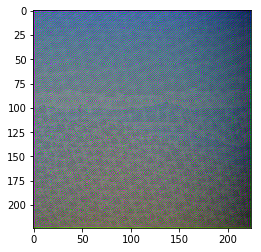

In [158]:
U.imshow(img_param.data)

torch.Size([3, 224, 224])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FC880A2DEF0>


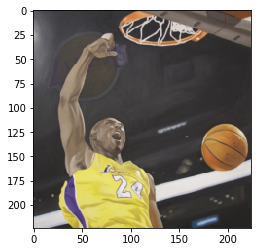

In [6]:
style_image  = Variable(U.get_image(9, 84))
style_image = style_image.cuda()
print(style_image.size())
U.imshow(style_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21FA6F2BA8>


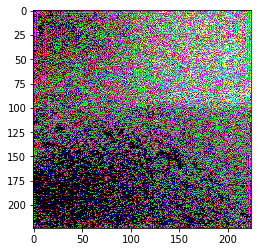

In [626]:
U.imshow(gen_image.data)

## 30 Epochs of Content Transfer
* Content Loss: 0.0005657271831296384 
* Total: 0.0005657271831296384
* Total Loss By Optimizer 0.00065893115242 ## why is this different?

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21D8035860>


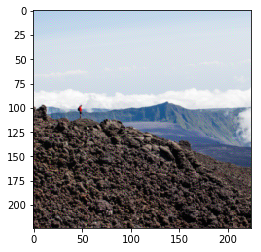

In [622]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F219F793C18>


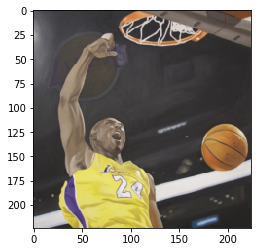

In [523]:
U.imshow(style_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21FA6C0BA8>


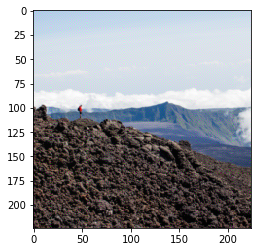

In [253]:
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21FA71D2E8>


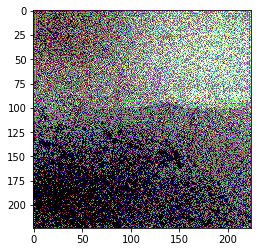

In [239]:
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21FA6FC278>


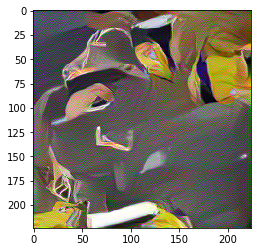

In [215]:
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21AC0F74A8>


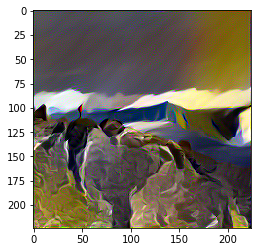

In [88]:
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F21AC0A4C50>


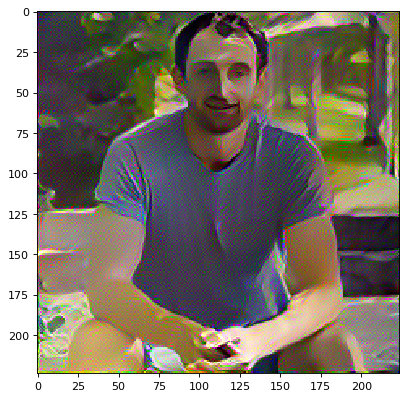

In [16]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8EF46A57F0>


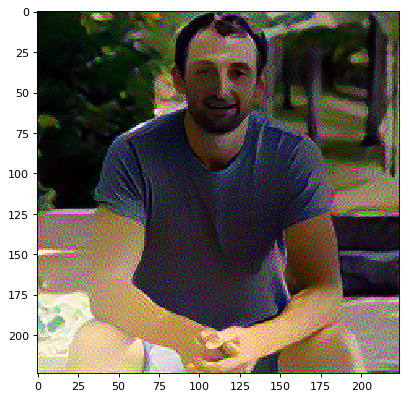

In [56]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FC8286712B0>


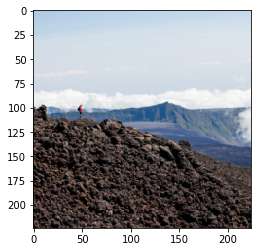

In [5]:
content_image = Variable(U.get_image(4, None, 112))
content_image = content_image.cuda()
U.imshow(content_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8EF47382B0>


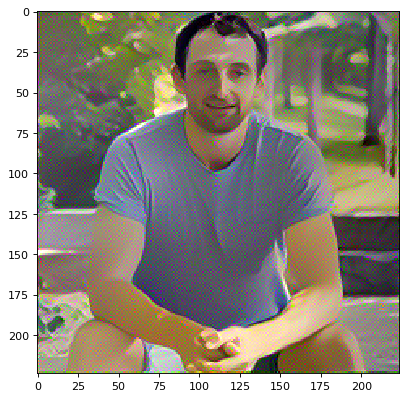

In [48]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8F242D4C18>


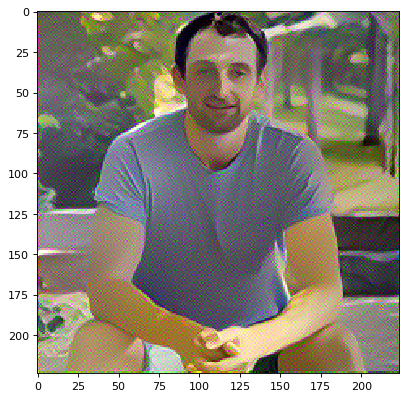

In [38]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8F18039898>


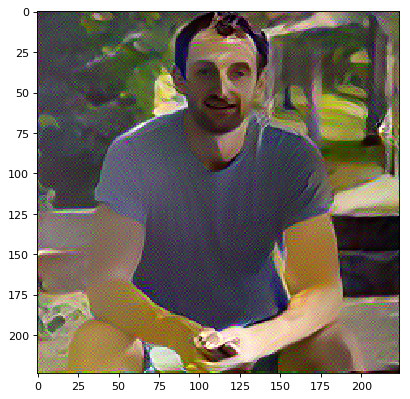

In [25]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F095C461198>


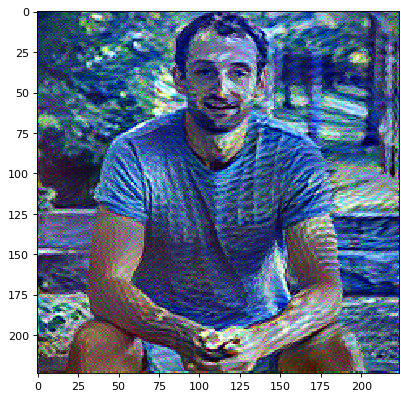

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)